In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import seaborn as sn
from pylab import subplot,imshow
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

import torch # pip3 install torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets # pip3 install torchvision
from torchvision.transforms import ToTensor

from torchinfo import summary # pip3 install torchinfo

import pytorch_lightning as pl # pip3 install pytorch-lightning

cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.35, 0.95, 256))) # np.linspace crea un vettore di numeri equidistanti tra 0.35 e 0.95

print(2)

2


/tmp/ipykernel_46766/2989228656.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_big = cm.get_cmap('Spectral', 512)


In [26]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#5D80AE', '#FC5758', '#0DD77D', '#FFC507', '#F64044', 
          '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

In [27]:
from typing import *

class History:
    """Accumulates values in a dictionary of sequences."""
    def __init__(self, keys: List[str]):
        self.data: Dict[str, List[float]]= {}
        self.keys: List[str] = keys
        for k in self.keys:
            self.data[k] = []

    def add(self, *args: Any):
        for k,a in zip(self.keys, args):
            self.data[k].append(a)

    def sums(self) -> Dict[str, float]:
        """
        Ho un dizionario di chiavi e liste di float. Questo metodo produce
        un nuovo dizionario con la stessa chiave e gli elementi della sequenza sommati
        """
        return {k: sum(self.data[k]) for k in self.keys}

    def merge(self, d: dict[str, List[float]]):
        """
        Unisce il dizionario di questo oggetto con il dizionario passato in input
        :param d: un dizionario con chiave string e lista di valori float
        """
        for k in self.keys:
            self.data[k].extend(d[k])

    def __getitem__(self, k: str) -> List[float]:
        """
        Restituisce la lista relativa alla chiave k
        :param k:
        :return:
        """
        return self.data[k]


def displayData(X: np.ndarray, t: np.ndarray, rows: int = 10, cols: int = 10, size: float = 8, class_value: bool = False):
    """
    Mostra le immagini del dataset e il valore target subito sopra ciascuna di esse, in forma di tabella.
    :param X: Le feature, ovvero le immagini che rappresentano le cifre del dataset MNIST di training
    :param t: Il target del dataset di training, ovvero un intero tra 0,1,...,9
    :param rows: il numero di righe della tabella
    :param cols: il numero di colonne della tabella
    :param size: la dimensione della tabella
    :param class_value: se true, mostra anche i valori target al di sopra di ogni immagini (come se fosse il titolo dell'immagine)
    :return:
    """
    X = X.numpy()
    t = t.numpy()
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 10, color=colors[4])
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off') 
    plt.subplots_adjust(top=1)
    plt.show()


def plotData(X, Y, c, npixel=28):
    X = X.numpy()
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()


def save_model_coeffs(m,filename):
    torch.save(m.state_dict(), filename)
    print("Saved model coefficients to disk")


def load_model_coeffs(m, filename):
    m.load_state_dict(torch.load(filename))
    print("Model coefficients loaded from disk")

In [28]:
def accuracy(preds, targets):  #@save
    """Compute the number of correct predictions."""
    # deal with the case when an array of probabilities is predict, by deriving the highest-probability class
    if len(preds.shape) > 1 and preds.shape[1] > 1:
        preds = preds.argmax(axis=1)
    cmp = preds.type(targets.dtype) == targets
    return float(cmp.type(targets.dtype).sum())


def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        # Set the model to eval mode
        net.eval()
    h_test = History(['correct_predictions', 'predictions'])  # No. of correct predictions, no. of predictions
    with torch.no_grad(): # Gradients must not be computed
        count = 0
        for X, y in data_iter:
            count += 1
            if count%10 == 0:
                print('x', end='')
            #X = X.flatten(start_dim=1, end_dim=-1)
            h_test.add(accuracy(net(X), y), len(y))
        s = h_test.sums()
    print(' ')
    return s['correct_predictions']/s['predictions']


def train_epoch(model, train_iter, loss_func, optimizer): 
    if isinstance(model, torch.nn.Module):
        model.train()  # Set the model to training mode
    h_epoch = History(['loss', 'correct_predictions', 'n_examples']) # Training loss, no. of correct predictions, no. of examples
    count = 0
    for X, y in train_iter:
        count += 1
        if count%10 == 0:
            print('.', end='')
        #X=X.flatten(start_dim=1, end_dim=-1)
        # Compute predictions
        y_hat = model(X)
        # Compute loss
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        h_epoch.add(float(loss), accuracy(y_hat, y), len(y))
    # Return training loss and training accuracy
    s = h_epoch.sums()
    return s['loss']/s['n_examples'], s['correct_predictions']/s['n_examples'], h_epoch


def train(net, loaders, loss_func, num_epochs, updater, report=False):
    h_batch = History(['loss', 'correct_predictions', 'n_examples'])
    h_train = History(['training_loss', 'training_accuracy', 'test_accuracy']) # Avg. training loss, avg. training accuracy, test accuracy
    for epoch in range(num_epochs):
        print(f'Epoch #{epoch+1}')
        # train model for one epoch
        train_loss, train_acc, h_epoch = train_epoch(net, loaders['train'], loss_func, updater)
        # evaluate accuracy on test set
        test_acc = evaluate_accuracy(net, loaders['test'])
        if report:
            print(f' Loss {train_loss:3.4f}, Training set accuracy {train_acc:1.4f}, Test set accuracy {test_acc:1.4f}')
        else:
            print('\n')
        h_train.add(train_loss, train_acc, test_acc)
        h_batch.merge(h_epoch.data)
    return h_train, h_batch


def predict(net, loaders):
    preds_train = []
    y_train = []
    preds_test = []
    y_test = []
    if isinstance(net, torch.nn.Module):
        net.eval()
    with torch.no_grad():
        for X, y in loaders['train']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(net(X),1)[1]).numpy()
            preds_train.extend(preds)
            y_train.extend(y.numpy())
        for X, y in loaders['test']:
            #X = X.flatten(start_dim=1, end_dim=-1)
            preds = (torch.max(net(X),1)[1]).numpy()
            preds_test.extend(preds)
            y_test.extend(y.numpy())
    return preds_train, y_train, preds_test, y_test

In [29]:
    
def plot_metrics(title, h, hb):
    losses = []
    accs = []
    for l, c, n in zip(hb.data['loss'], hb.data['correct_predictions'], hb.data['n_examples']):
        losses.append(l/n)
        accs.append(c/n)
    n = len(accs)
    step = int(n/num_epochs)
    xs = range(step-1, n+step-1, step)

    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
    ax1.plot(range(len(losses)),losses, color= colors[0], lw=.5, label='Loss by batch', zorder=2)
    ax1.scatter(xs, h.data['training_loss'], color=colors[1], edgecolors='black', label='Loss by epoch', zorder=2)
    for x in xs:
        ax1.axvline(x, lw=1, color='gray', zorder=1)
    ax1.legend()
    ax1.set_title('Loss')
    ax2.plot(range(len(accs)),accs, color= colors[0], lw=.5, label='Training set accuracy by batch', zorder=2)
    ax2.scatter(xs, h.data['training_accuracy'], color=colors[1], edgecolors='black', label='Training set accuracy by epoch', zorder=2)
    ax2.scatter(xs, h.data['test_accuracy'], color=colors[2], edgecolors='black', label='Test set accuracy by epoch', zorder=2)
    for x in xs:
        ax2.axvline(x, lw=1, color='gray', zorder=1)
    ax2.legend()
    ax2.set_title('Accuracy')
    plt.suptitle(title)
    plt.show()


def plot_label_dist(predictions_probs, predicted_class, true_label):
      plt.figure(figsize = (4,4))
      thisplot = plt.bar(range(10), predictions_probs, color="#77aaaa")
      plt.ylim([0, 1]) 
      thisplot[predicted_class].set_color(colors[0])
      thisplot[true_label].set_edgecolor(colors[4])
      thisplot[true_label].set_linewidth(1)
      plt.grid(False)
      plt.xticks(range(10))
      plt.yticks([])
      plt.show()

Read training and test sets into Pytorch datasets

In [30]:
# Converts a PIL Image or numpy.ndarray (h x w x n) in the range [0, 255] to a torch.FloatTensor of shape (n x h x w)
trans = ToTensor()

mnist_train = datasets.MNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = datasets.MNIST(root="../data", train=False, transform=trans, download=True)

In [31]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [32]:
mnist_train.targets.shape

torch.Size([60000])

Features are organized in a 3-dimensional tensor of size $n\times h\times w$ of $n$ items (matrices), each of $h$ rows and $w$ columns. Targets are organized as a 1d tensor of size $n$

In [33]:
print(f'Training set features: n={mnist_train.data.numpy().shape[0]}, h={mnist_train.data.numpy().shape[1]}, w={mnist_train.data.numpy().shape[2]}')
print(f'Training set targets: n={mnist_train.targets.numpy().shape[0]}')

Training set features: n=60000, h=28, w=28
Training set targets: n=60000


The test set is organized in the same way, with a different value of $n$

In [34]:
print(f'Test set features: n={mnist_test.data.numpy().shape[0]}, h={mnist_test.data.numpy().shape[1]}, w={mnist_test.data.numpy().shape[2]}')
print(f'Test set targets: n={mnist_test.targets.numpy().shape[0]}')

Test set features: n=10000, h=28, w=28
Test set targets: n=10000


An image is coded as a matrix 28x28 reals in [0,1] (higher value = darker color)

In [35]:
print(mnist_train.data[0,:,:])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

/tmp/ipykernel_46766/3081785000.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(10,10,i+1)


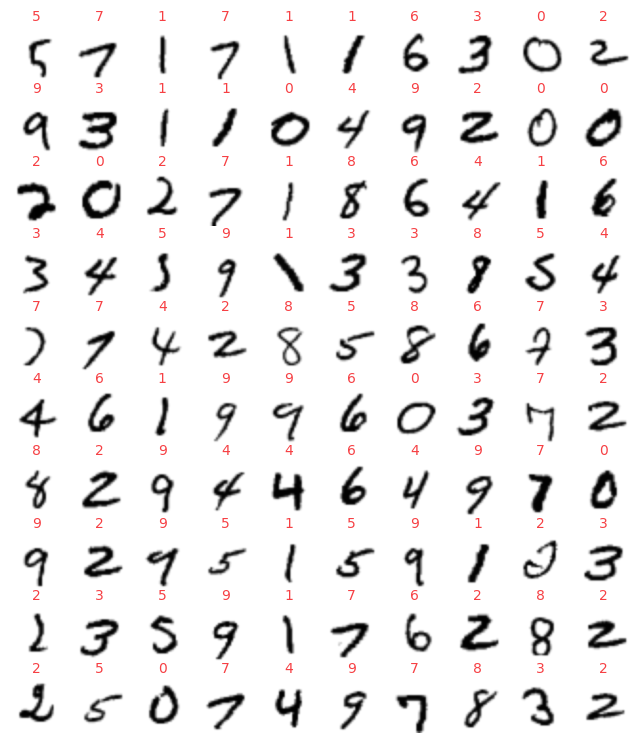

In [49]:
displayData(mnist_train.data[100:200], mnist_train.targets[100:200], class_value=True)

Target values

In [37]:
mnist_train.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

Target values one-hot encoded

In [38]:
torch.nn.functional.one_hot(mnist_train.targets[:10])

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [39]:
height = mnist_train.data.shape[1]
width = mnist_train.data.shape[2]
num_classes = mnist_train.targets.unique().shape[0]

Define data loaders to provide datasets batches during the training process

In [40]:
batch_size = 100

loaders = {'train' : DataLoader(mnist_train, batch_size=batch_size, shuffle=True),
           'test'  : DataLoader(mnist_test, batch_size=batch_size, shuffle=True)}

First approach: 
*   For each class, compute a linear combination of the ($28\times 28 =784$) values $x_i, i=1,\ldots, 784$ of the image, plus a constant (*bias*) $b$: that is, $785$ coefficients $w_1,\ldots, w_{784}, b$ must be defined for each class, for a total number of $785\times 10=7850$ coefficients
*   For each class, to the value resulting from the linear combination $$\sum_{i=1}^{784}w_ix_i+b$$ a suitable nonlinear function is applied (in this case the *exponential* function $e^{x}$)
*   The resulting values, one for each class, are *normalized* to sum to $1$
*   The result can be interpreted as a set of probabilities, associated to the set of disjoint events: the image belongs to the $i$-th class (it is a $0, 1, \ldots, 9$)
*   A strategy for assigning the image to a class can then be applied, such as assigning to the class of largest probability. In case, risk minimization approaches can be applied

In [41]:
class NeuralNet0(nn.Module):
    def __init__(self, w, h, num_classes):
         super(NeuralNet0, self).__init__()
         self.f = nn.Flatten()
         self.l1 = nn.Linear(w*h, num_classes)   
         self.ls = nn.LogSoftmax(dim=1)

    def forward(self, x):
         out = self.f(x)
         out = self.l1(out)
         out = self.ls(out)
         return out 

Create the network

In [42]:
model0 = NeuralNet0(height, width, num_classes)

In [43]:
summary(model0, input_size=(batch_size, height*width))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet0                               [100, 10]                 --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 10]                 7,850
├─LogSoftmax: 1-3                        [100, 10]                 --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.31
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.35

Define a loss function and a gradient descent method

In [44]:

learning_rate = 0.001

loss_func0 = nn.NLLLoss(reduction='sum')
optimizer0 = torch.optim.Adam(model0.parameters(), lr=learning_rate)

In [45]:
num_epochs = 3

In [46]:
h, h_batch = train(model0, loaders, loss_func0, num_epochs, optimizer0, report=True)

Epoch #1


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
plot_metrics('Softmax', h, h_batch)

In [ ]:
save_model_coeffs(model0, 'softmax')

In [ ]:
#load_model_coeffs(model0, 'softmax')

In [ ]:
ptr, ytr, pte, yte = predict(model0, loaders)

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()

Accuracy: $$\frac{\text{\# items classified correctly}}{\text{\# items}}$$

Precision class $i$: $$\frac{\text{\# items from class $i$ classified correctly}}{\text{\# items classified as class $i$}}$$

Recall class $i$: $$\frac{\text{\# items from class $i$ classified correctly}}{\text{\# items from class $i$}}$$

F-score class $i$: $$\frac{\text{Precision classe $i$} \times \text{Recall classe $i$}}{\text{Precision classe $i$}+\text{Recall classe $i$}}$$

In [ ]:
print('Training set')
print(classification_report(ytr, ptr))

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()

In [ ]:
print('Test set')
print(classification_report(yte, pte))

In [ ]:
X=next(iter(loaders['train']))[0]

In [ ]:
X.numpy().shape

In [ ]:
idx = 21
x = trans(mnist_train.data[idx,:,:].numpy())#.flatten(start_dim=0, end_dim=-1)
y = mnist_train.targets[idx].numpy()
image = mnist_train.data[idx,:,:].numpy()
plt.figure(figsize = (4,4))
plt.imshow(image, cmap='Greys', interpolation='quadric')
plt.grid(None)
plt.axis('off')
plt.show()

In [ ]:
print(f"This is a {y}")

In [ ]:
predict0 = model0(x)

predictions_probs = torch.exp(predict0).detach().squeeze()
predicted_class = np.squeeze(np.argmax(predictions_probs, axis=-1))
print("Predicted probabilities: ["+", ".join('%5.4f'%x for x in predictions_probs)+"]")
print(f"Class: {y}. Prediction: {predicted_class}")

In [ ]:
plot_label_dist(predictions_probs, predicted_class, y)

In [ ]:
class NeuralNet1(nn.Module):
    def __init__(self, h, w, hidden_size, num_classes):
        super(NeuralNet1, self).__init__()
        self.f = nn.Flatten()
        self.l1 = nn.Linear(w*h, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.ls = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.f(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.ls(out)
        return out

In [ ]:
hidden_size = 512
model1 = NeuralNet1(height, width, hidden_size, num_classes)

In [ ]:
summary(model1)

In [ ]:
learning_rate = 0.001

loss_func1 = nn.NLLLoss(reduction='sum')
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 3

In [ ]:
h, h_batch = train(model1, loaders, loss_func1, num_epochs, optimizer1, report=True)

In [ ]:
plot_metrics('3-layer MLP', h, h_batch)

In [ ]:

ptr, ytr, pte, yte = predict(model1, loaders)

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()           

In [ ]:
print('Training set')
print(classification_report(ytr, ptr))

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()

In [ ]:
print('Test set')
print(classification_report(yte, pte))

In [ ]:
hidden_size1 = 512
hidden_size2 = 256

dropout_rate1 = .2
dropout_rate2 = .2

In [ ]:
class NeuralNet2(nn.Module):
    def __init__(self, h, w, hidden_size1, hidden_size2, dropout_rate1, dropout_rate2, num_classes):
        super(NeuralNet2, self).__init__()
        self.f = nn.Flatten()
        self.l1 = nn.Linear(w*h, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2) 
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate2)
        self.l3 = nn.Linear(hidden_size2, num_classes)
        self.ls = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.f(x)
        out = self.l1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.l3(out)
        out = self.ls(out)
        return out

In [ ]:
model2 = NeuralNet2(height, width, hidden_size1, hidden_size2, dropout_rate1, dropout_rate2, num_classes)

In [ ]:
s = 0
for name, param in model2.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, {param.numel()} coefficients")
    s += param.numel()
print(f"{s} coefficients overall")

In [ ]:
learning_rate = 0.001

loss_func2 = nn.NLLLoss(reduction='sum')
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 3

In [ ]:
h, h_batch = train(model2, loaders, loss_func2, num_epochs, optimizer2, report=True)

In [ ]:
plot_metrics('4-layer MLP', h, h_batch)

In [ ]:
ptr, ytr, pte, yte = predict(model2, loaders)

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()   

In [ ]:
print('Training set')
print(classification_report(ytr, ptr))

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()   

In [ ]:
print('Test set')
print(classification_report(yte, pte))

In [ ]:
class NeuralNet3(nn.Module):
    def __init__(self, n_channels, num_classes):
        super(NeuralNet3, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 4, 5)# input (1,28,28) output (4, 24, 24)
        self.bn1 = nn.BatchNorm2d(4)# input (4, 24, 24) output (4, 24, 24)
        self.relu1 = nn.ReLU()# input (4, 24, 24) output (4, 24, 24)
        self.pool1 = nn.MaxPool2d(2, 2)# input (4, 24, 24) output (4, 12, 12)
        self.conv2 = nn.Conv2d(4, 6, 3)# input (4, 12, 12) output (6, 10, 10)
        self.bn2 = nn.BatchNorm2d(6)# input (6, 10, 10) output (6, 10, 10)
        self.relu2 = nn.ReLU()# input (6, 10, 10) output (6, 10, 10)
        self.pool2 = nn.MaxPool2d(3, 2)# input (6, 10, 10) output (6, 4, 4)
        self.f = nn.Flatten()
        self.l1 = nn.Linear(6*4*4, 32) 
        self.relu1 = nn.ReLU()
        self.l3 = nn.Linear(32, num_classes)
        self.ls = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = self.f(out)
        out = self.l1(out)
        out = self.relu1(out)
        out = self.l3(out)
        out = self.ls(out)
        return out

In [ ]:
n_channels = 1
model3 = NeuralNet3(n_channels, num_classes)

In [ ]:
print(model3)

In [ ]:
s = 0
for name, param in model3.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, {param.numel()} coefficients")
    s += param.numel()
print(f"{s} coefficients overall")

In [ ]:
learning_rate = 0.001

loss_func3 = nn.NLLLoss(reduction='sum')
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 3

In [ ]:
h, h_batch = train(model3, loaders, loss_func3, num_epochs, optimizer3, report=True)

In [ ]:
plot_metrics('Convolutional', h, h_batch)

In [ ]:
ptr, ytr, pte, yte = predict(model3, loaders)

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()  

In [ ]:
print('Training set')
print(classification_report(ytr, ptr))

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()  

In [ ]:
print('Test set')
print(classification_report(yte, pte))

In [ ]:
class NeuralNet4(nn.Module):
    def __init__(self, n_channels, num_classes):
        super(NeuralNet4, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 12, kernel_size=3, stride=1, padding=2)# input (1,28,28) output (12, 30, 30)
        self.bn1 = nn.BatchNorm2d(12)# input (12, 30, 30) output (12, 30, 30)
        self.relu1 = nn.ReLU()# input (12, 30, 30) output (12, 30, 30)
        self.pool1 = nn.AvgPool2d(2, 2)# input (12, 30, 30) output (12, 15, 15)
        self.conv2 = nn.Conv2d(12, 6, kernel_size=3)# input (12, 15, 15) output (6, 13, 13)
        self.bn2 = nn.BatchNorm2d(6)# input (6, 13, 13) output (6, 13, 13)
        self.relu2 = nn.ReLU()# input (6, 13, 13) output (6, 13, 13)
        self.f = nn.Flatten()# input (6, 13, 13) output (1014)
        self.d = nn.Dropout(p=.3)# input (1014) output (1014)
        self.l1 = nn.Linear(1014, 64)# input (1014) output (64)
        self.relu3 = nn.ReLU()# input (64) output (64)
        self.l3 = nn.Linear(64, num_classes)# input (64) output (10)
        self.ls = nn.LogSoftmax(dim=1)# input (10) output (10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.f(out)
        out = self.d(out)
        out = self.l1(out)
        out = self.relu3(out)
        out = self.l3(out)
        out = self.ls(out)
        return out

In [ ]:
n_channels = 1
model4 = NeuralNet4(n_channels, num_classes)

In [ ]:
print(model4)

In [ ]:
s = 0
for name, param in model4.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, {param.numel()} coefficients")
    s += param.numel()
print(f"{s} coefficients overall")

In [ ]:
learning_rate = 0.001

loss_func4 = nn.NLLLoss(reduction='sum')
optimizer4 = torch.optim.Adam(model4.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 2
h, h_batch = train(model4, loaders, loss_func4, num_epochs, optimizer4, report=True)

In [ ]:
plot_metrics('Convolutional 2', h, h_batch)

In [ ]:
ptr, ytr, pte, yte = predict(model4, loaders)

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(ytr, ptr, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Training Set")
plt.grid(None)
plt.show()  

In [ ]:
print('Training set')
print(classification_report(ytr, ptr))

In [ ]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, pte, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix Test Set")
plt.grid(None)
plt.show()  

In [ ]:
print('Test set')
print(classification_report(yte, pte))